# Plan of Action

**Our age prediction CNN model shall be defined and trained by**:
1. Importing **training and test datasets** from Google Drive Input Sub-folder
2. **Training dataset is already augmented** and has 234,000 images
3. **Greyscaling images** instead of using RGB color images
4. Defining our intuitively **distributed classes of age-ranges**
5. Using **60 epochs** on our **optimized CNN Architecture**, comprising of:
    - an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
    - 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
    - a *GlobalAveragePooling2D* layer,
    - 1 *Dense* layer with 132 nodes, and
    - an output *Dense* layer with 7 nodes.

# Mount Google Drive & Imports

In [1]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.


In [2]:
import matplotlib.pyplot as plt

import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
from common_utils import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

2025-04-02 10:08:57.749760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 10:08:57.795120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 10:08:57.795167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 10:08:57.796514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 10:08:57.803819: I tensorflow/core/platform/cpu_feature_guar

In [3]:
#@title Check for GPU

# Testing to ensure GPU is being utilized
# Ensure that the Runtime Type for this notebook is set to GPU
# If a GPU device is not found, change the runtime type under: Runtime>> Change runtime type>> Hardware accelerator>> GPU
# and run the notebook from the beginning again.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2025-04-02 10:08:59.480421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:63:00.0, compute capability: 8.9


# Data Preparation

## Import Dataset

In [4]:
# Unzipping the dataset file combined_faces.zip

# combined_faces_zip_path = "/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/combined_faces.zip"

# with ZipFile(combined_faces_zip_path, 'r') as myzip:
#     myzip.extractall()
#     print('Done unzipping combined_faces.zip')

In [5]:
# Unzipping the dataset file combined_faces.zip

# combined_faces_zip_path = "/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/combined_faces_train_augmented.zip"
# 
# with ZipFile(combined_faces_zip_path, 'r') as myzip:
#     myzip.extractall()
#     print('Done unzipping combined_faces_train_augmented.zip')

In [6]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

image_paths_csv = pd.read_csv("./processed_data/image_paths.csv")
paths_train_df, paths_val_df, paths_test_df = split_data(image_paths_csv)


# test_df = pd.read_csv("/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/images_filenames_labels_test.csv")

## Organize Dataset

In [7]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

paths_train_df_list = list(paths_train_df['path'])
paths_train_labels_list = list(paths_train_df['age_bin'])


paths_test_df_list = list(paths_test_df['path'])
paths_test_labels_list = list(paths_test_df['age_bin'])


In [8]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(paths_train_df_list)
train_aug_labels_tensor = tf.constant(paths_train_labels_list)

test_filenames_tensor = tf.constant(paths_test_df_list)
test_labels_tensor = tf.constant(paths_test_labels_list)


2025-04-02 10:08:59.553217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:63:00.0, compute capability: 8.9


# Image Greyscale Function

In [9]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 13

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [10]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

# CNN Architecture

In [11]:
# Defining the architecture of the sequential neural network.

model=build_sequential_cnn_model(
    channels=1,
    dropout_rate=0,
    task="classification",
    num_classes=13,
    num_conv_layers=4,
    conv_filters=[32, 64, 128, 256],
    kernel_size=3,
    activation="relu",
    num_dense_layers=1,
    dense_units=[132],
    output_activation="softmax"
)

final_cnn = Sequential([
    Input(shape=(200, 200, 1)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=128, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=256, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    GlobalAveragePooling2D(),
    Dense(132, activation='relu'),
    Dense(13, activation='softmax')
])
final_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_4 (Avera  (None, 99, 99, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_5 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 128)      

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

In [13]:
# Compiling the above created CNN architecture.


model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # Fixed loss function.
        metrics=['accuracy']
    )
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Creating a TensorBoard callback object and saving it at the desired location.

We shall also use ***ModelCheckpoint*** as a callback while training the final CNN model so as to be able to save the model as it continues training and improving in performance over 60 epochs.

In [15]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

# checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5",
#                              monitor='val_accuracy',
#                              save_best_only=True,
#                              save_weights_only=False,
#                              verbose=1
#                             )

# Model Fitting

In [17]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  verbose=2,
                                  # callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )





Epoch 1/60
14/14 - 4s - loss: 5.5227 - accuracy: 0.1217 - val_loss: 2.4601 - val_accuracy: 0.1421 - 4s/epoch - 280ms/step
Epoch 2/60
14/14 - 2s - loss: 2.4445 - accuracy: 0.1650 - val_loss: 2.4505 - val_accuracy: 0.1421 - 2s/epoch - 155ms/step
Epoch 3/60
14/14 - 2s - loss: 2.4372 - accuracy: 0.1779 - val_loss: 2.4297 - val_accuracy: 0.2163 - 2s/epoch - 153ms/step
Epoch 4/60
14/14 - 2s - loss: 2.4182 - accuracy: 0.1924 - val_loss: 2.4303 - val_accuracy: 0.1588 - 2s/epoch - 154ms/step
Epoch 5/60
14/14 - 2s - loss: 2.4022 - accuracy: 0.1933 - val_loss: 2.3891 - val_accuracy: 0.2153 - 2s/epoch - 155ms/step
Epoch 6/60
14/14 - 2s - loss: 2.3567 - accuracy: 0.2303 - val_loss: 2.3416 - val_accuracy: 0.2372 - 2s/epoch - 154ms/step
Epoch 7/60
14/14 - 2s - loss: 2.3306 - accuracy: 0.2329 - val_loss: 2.3328 - val_accuracy: 0.2403 - 2s/epoch - 154ms/step
Epoch 8/60
14/14 - 2s - loss: 2.3026 - accuracy: 0.2442 - val_loss: 2.2756 - val_accuracy: 0.2330 - 2s/epoch - 160ms/step
Epoch 9/60
14/14 - 2s - 

In [16]:
history=model.fit(
        train_aug_dataset,
        batch_size=512,
        validation_data=test_dataset,
        epochs=60,
        verbose=2,
        shuffle=False
    )

Epoch 1/60


2025-04-02 10:09:29.824729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-02 10:09:32.200991: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c1ea9939550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 10:09:32.201061: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-04-02 10:09:32.208357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743588572.317375    6901 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 - 17s - loss: 5.2671 - accuracy: 0.1074 - val_loss: 2.4962 - val_accuracy: 0.1578 - 17s/epoch - 1s/step
Epoch 2/60
14/14 - 2s - loss: 2.4568 - accuracy: 0.1561 - val_loss: 2.4541 - val_accuracy: 0.2278 - 2s/epoch - 148ms/step
Epoch 3/60
14/14 - 2s - loss: 2.4279 - accuracy: 0.1821 - val_loss: 2.4795 - val_accuracy: 0.1630 - 2s/epoch - 154ms/step
Epoch 4/60
14/14 - 2s - loss: 2.4369 - accuracy: 0.1899 - val_loss: 2.4527 - val_accuracy: 0.1693 - 2s/epoch - 150ms/step
Epoch 5/60
14/14 - 2s - loss: 2.3871 - accuracy: 0.2100 - val_loss: 2.3840 - val_accuracy: 0.2069 - 2s/epoch - 147ms/step
Epoch 6/60
14/14 - 2s - loss: 2.3639 - accuracy: 0.2297 - val_loss: 2.6032 - val_accuracy: 0.1567 - 2s/epoch - 153ms/step
Epoch 7/60
14/14 - 2s - loss: 2.3694 - accuracy: 0.2221 - val_loss: 2.3130 - val_accuracy: 0.2194 - 2s/epoch - 154ms/step
Epoch 8/60
14/14 - 2s - loss: 2.2885 - accuracy: 0.2442 - val_loss: 2.2958 - val_accuracy: 0.2309 - 2s/epoch - 149ms/step
Epoch 9/60
14/14 - 2s - loss: 2.2269

# Checking Model Performance

In [21]:
final_cnn_history

In [22]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']


train_loss_func = history.history['loss']
test_loss_func = history.history['val_loss']
train_accuracy_func = history.history['accuracy']
test_accuracy_func = history.history['val_accuracy']


Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

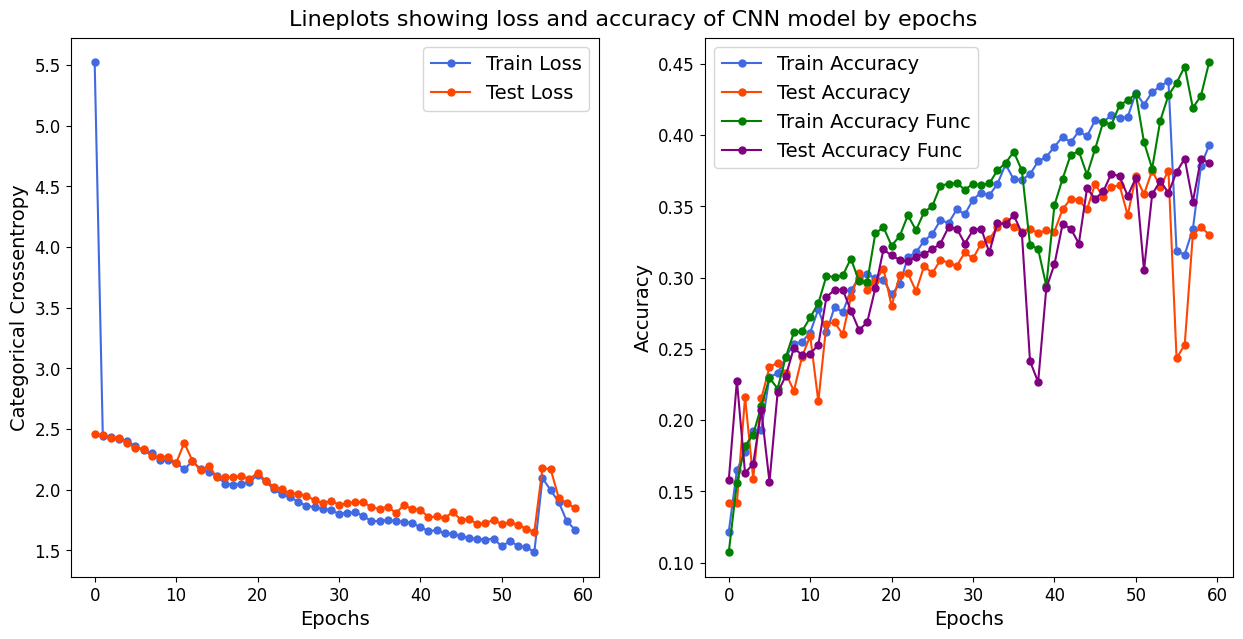

In [23]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].plot(train_accuracy_func, label='Train Accuracy Func', color='green', marker='o', markersize=5)
ax[1].plot(test_accuracy_func, label='Test Accuracy Func', color='purple', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [24]:

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)
model_score = model.evaluate(test_dataset, verbose=1)

2/2 [==============================] - 0s 67ms/step - loss: 1.6971 - accuracy: 0.3804


In [25]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

model_labels = model.metrics_names
print(f'Func model {model_labels[0]} \t= {round(model_score[0], 3)}')
print(f'Func model {model_labels[1]} \t= {round(model_score[1], 3)}')

CNN model loss 		= 1.848
CNN model accuracy 	= 0.33
Func model loss 	= 1.697
Func model accuracy 	= 0.38


In [ ]:
# Saving the model as a h5 file for possible use later.

### Plotting Confusion Matrix

In [30]:
# Generating predictions from the model above.

final_cnn_pred = model.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 53ms/step


In [31]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(paths_test_labels_list, final_cnn_pred)
conf_mat

array([[125,   5,   0,   2,   0,   0,   2,   0,   0,   0,   2,   0,   0],
       [ 25,  18,   7,  11,   1,   2,   6,   1,   0,   0,   1,   0,   1],
       [  3,   4,   7,   8,   4,   7,  11,   0,   0,   0,   0,   0,   0],
       [  2,   4,   2,  11,   3,   6,   7,   0,   4,   0,   1,   0,   0],
       [  0,   1,   2,   6,   9,   7,  19,   2,   1,   0,   0,   0,   0],
       [  0,   2,   1,   0,   7,  29,  49,   2,   0,   0,   2,   0,   0],
       [  0,   0,   1,   3,   4,  20, 103,  11,   6,   1,   2,   0,   0],
       [  0,   1,   0,   1,   2,   4,  52,  11,  10,   1,   4,   0,   0],
       [  1,   1,   1,   4,   5,   3,  40,   8,  14,   0,  18,   1,   0],
       [  0,   0,   0,   4,   2,   3,  14,   6,  19,   1,  20,   0,   5],
       [  2,   0,   0,   2,   0,   2,   6,   1,  10,   0,  21,   0,   5],
       [  2,   0,   0,   1,   0,   3,   3,   0,   4,   0,  16,   0,  11],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   2,  10,   0,  15]])

In [32]:
conf_mat_func = confusion_matrix(paths_test_labels_list, model.predict(test_dataset).argmax(axis=-1))
conf_mat_func

2/2 [==============================] - 0s 59ms/step


array([[125,   5,   0,   2,   0,   0,   2,   0,   0,   0,   2,   0,   0],
       [ 25,  18,   7,  11,   1,   2,   6,   1,   0,   0,   1,   0,   1],
       [  3,   4,   7,   8,   4,   7,  11,   0,   0,   0,   0,   0,   0],
       [  2,   4,   2,  11,   3,   6,   7,   0,   4,   0,   1,   0,   0],
       [  0,   1,   2,   6,   9,   7,  19,   2,   1,   0,   0,   0,   0],
       [  0,   2,   1,   0,   7,  29,  49,   2,   0,   0,   2,   0,   0],
       [  0,   0,   1,   3,   4,  20, 103,  11,   6,   1,   2,   0,   0],
       [  0,   1,   0,   1,   2,   4,  52,  11,  10,   1,   4,   0,   0],
       [  1,   1,   1,   4,   5,   3,  40,   8,  14,   0,  18,   1,   0],
       [  0,   0,   0,   4,   2,   3,  14,   6,  19,   1,  20,   0,   5],
       [  2,   0,   0,   2,   0,   2,   6,   1,  10,   0,  21,   0,   5],
       [  2,   0,   0,   1,   0,   3,   3,   0,   4,   0,  16,   0,  11],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   2,  10,   0,  15]])

In [35]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'./output/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


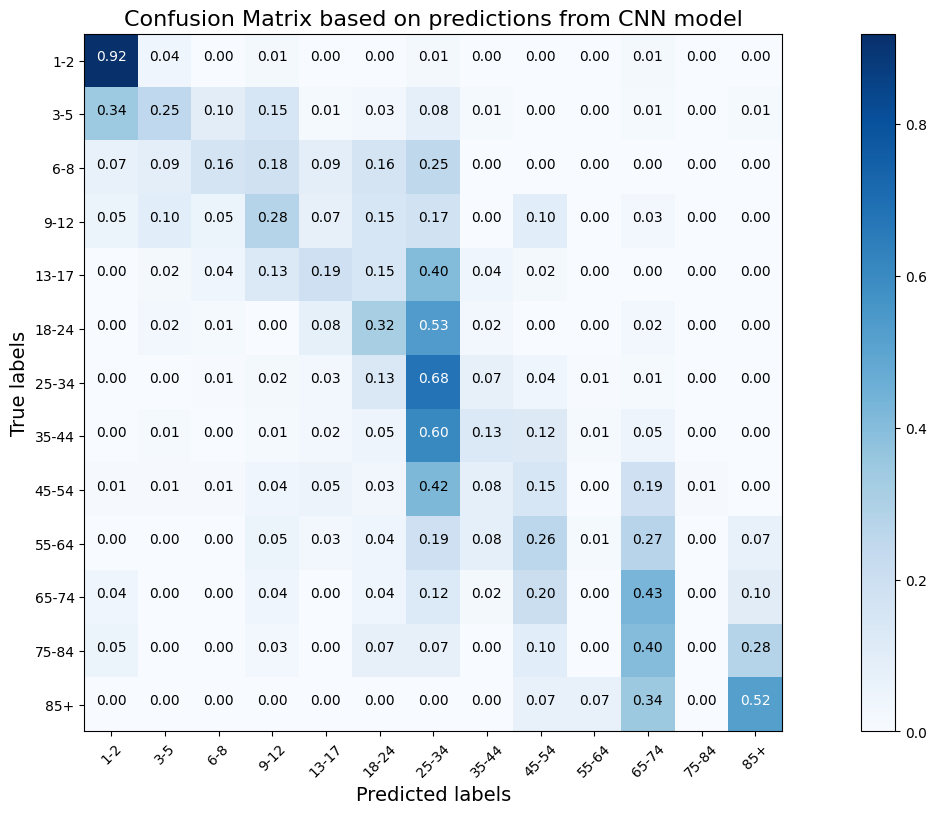

In [36]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-5', '6-8', '9-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

Below is the **final summary of age prediction CNN model**.


As with any data science workflow, the deep learning approach presented above does have its own limitations as well. For instance, the original datasets used in this project only had about 33,000 images when combined together. Even though the training dataset was augmented to increase it's size from 23,440 images to 234,400 images, there is always a possibility that an **even larger training dataset with more variation in the images would have resulted in even better results**.

Another approach to this project could be to use **Transfer Learning (using the architecture and layer weights from a pre-trained neural network)** instead of creating and training a neural network from scratch.

Ref: https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2 by Prerak Agarwal